# SAM-Based Cropping for Mammogram Preprocessing

This notebook uses the **Segment Anything Model 2 (SAM2)** to segment mammograms and crop the breast tissue by removing as much background as possible. This preprocessing step is intended to improve model focus and interpretability during classification.

The notebook includes:

- Setup for local and Kaggle environments
- SAM2 installation and model loading
- Segmentation of breast tissue
- Cropping and saving preprocessed images

**Note:**  
This notebook was developed and run in a **Kaggle environment**, which provides GPU access and sufficient compute for segmentation tasks. Ensure you upload the required image folder and model checkpoint (`sam_vit_h.pth`) to the Kaggle workspace before execution.


In [ ]:
import torch
import torchvision

import os
import shutil
import platform

In [ ]:
# Detect whether running in a Kaggle environment
using_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# Define base paths
HOME = "/kaggle/input" if using_kaggle else "./"
input_dir = os.path.join(HOME, "mammogram-images")  # Change this to your folder name
output_dir = "./preprocessed-crops"

os.makedirs(output_dir, exist_ok=True)


In [1]:
#!git clone https://github.com/facebookresearch/segment-anything-2.git

In [4]:
torch.backends.cudnn.benchmark = True  # Optimizes for fixed-size inputs
torch.backends.cudnn.enabled = True    # Ensures CUDA is used efficiently
#torch.set_num_threads(1)  # Prevents PyTorch from using CPU threads

In [5]:
torch.cuda.empty_cache()  # Frees unused memory
torch.cuda.ipc_collect()  # Helps free memory from inter-process communication

In [ ]:
if using_kaggle:
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    # Install necessary libraries
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    # Change directory to segment-anything-2
    %cd {HOME}/segment-anything-2

    # Ensure the checkpoints directory exists
    !mkdir -p ../checkpoints/

    # Download the model checkpoint (if not already available)
    !wget -nc -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt


In [7]:
# if using Apple MPS, fall back to CPU for unsupported ops
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from math import ceil

import cv2
import numpy as np

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

using device: cuda


In [ ]:
# some of the following functions were taken from 
# https://www.kaggle.com/code/shravankumar147/sam2-getting-started
# and modified

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    


def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


def get_bounding_box(mask):
    """Finds the bounding box around the largest contour in the mask."""
    mask = mask.astype(np.uint8)  # Ensure it's a binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None  # No contours found
    
    largest_contour = max(contours, key=cv2.contourArea)  # Select the largest area
    x, y, w, h = cv2.boundingRect(largest_contour)  # Get bounding box
    
    return [x, y, x + w, y + h]  # Convert to [x_min, y_min, x_max, y_max]

def black_pixel(pixel, threshold=50):
    """Checks if the given RGB pixel is black or nearly black.
    Return True if the pixel is black or near-black, False otherwise"""
    return np.all(pixel <= threshold)  # Check if all RGB values are below the threshold

def get_coords(img_path, img, threshold=50):
    # initially assume the image name correctly gives the position of the breast in the image
    if "LEFT" in img_path:
        x1 = ceil(img.shape[1]/4)
        x2 = ceil(img.shape[1]/4)
    else:
        x1 = ceil(5 * img.shape[1]/6)
        x2 = ceil(5 * img.shape[1]/6)
    
    y1 = ceil(img.shape[0]/2) + 300
    y2 = ceil(img.shape[0]/2) - 300    
    
    # check that the points taken on the image is not black
    pixel1_value = img[y1, x1]  # Get RGB values at (x1, y1)
    pixel2_value = img[y2, x2]  # Get RGB values at (x2, y2)

    if black_pixel(pixel1_value, threshold) or black_pixel(pixel2_value, threshold):
        if "LEFT" in img_path:
            x1 = ceil(5 * img.shape[1]/6)
            x2 = ceil(5 * img.shape[1]/6)
        else:
            x1 = ceil(img.shape[1]/4)
            x2 = ceil(img.shape[1]/4)
        
        # update pixel value
        pixel1_value = img[y1, x1]  # Get RGB values at (x1, y1)
        pixel2_value = img[y2, x2]  # Get RGB values at (x2, y2)
        
        if black_pixel(pixel1_value, threshold) or black_pixel(pixel2_value, threshold):
            print("No point found: ", img_path)
            return (-1, -1, -1, -1)
        #print("Coordinates were changed")

    return (x1, y1, x2, y2)


def expand_bounding_box(bbox, image_shape, padding=10):
    """
    Expands the bounding box by a given padding while ensuring it stays within image boundaries.

    Args:
    - bbox (tuple): (x_min, y_min, x_max, y_max)
    - image_shape (tuple): (height, width, channels)
    - padding (int): Pixels to expand on each side.

    Returns:
    - Expanded bounding box (x_min, y_min, x_max, y_max)
    """
    x_min, y_min, x_max, y_max = bbox
    img_h, img_w = image_shape[:2]  # Get image height & width

    # Expand and ensure the coordinates remain in the valid image range
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(img_w, x_max + padding)
    y_max = min(img_h, y_max + padding)

    return (x_min, y_min, x_max, y_max)


def crop_image(image, bbox):
    """
    Crop the image using the bounding box coordinates.
    """
    x_min, y_min, x_max, y_max = bbox

    # Crop using numpy slicing
    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image

(4616, 3016, 3)


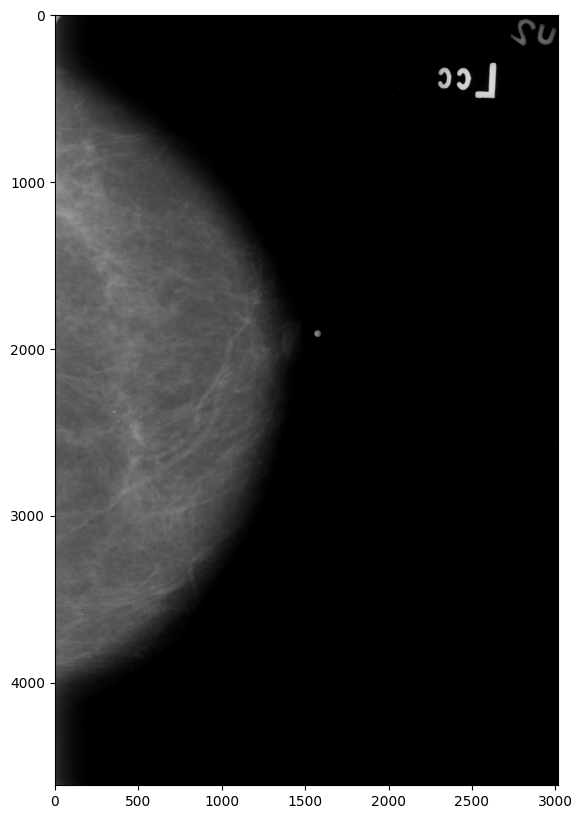

In [ ]:
## Example images (4 types of images)
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png/images/Calc-Test_P_00038_LEFT_CC_FULL.png"

image = Image.open(image_path)
image = np.array(image.convert("RGB"))

print(image.shape)

(x1, y1, x2, y2) = get_coords(image_path, image, threshold=30)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

predictor.mask_threshold = 0.5

In [294]:
predictor.set_image(image)

In [ ]:
pixel1_value = image[y1, x1]  # Get RGB values at (x, y)
pixel2_value = image[y2, x2]

print(f"Pixel1 RGB values at ({x1}, {y1}): {pixel1_value}")
print(f"Pixel2 RGB values at ({x2}, {y2}): {pixel2_value}")


Pixel1 RGB values at (400, 2946): [83 83 83]
Pixel2 RGB values at (400, 2146): [187 187 187]


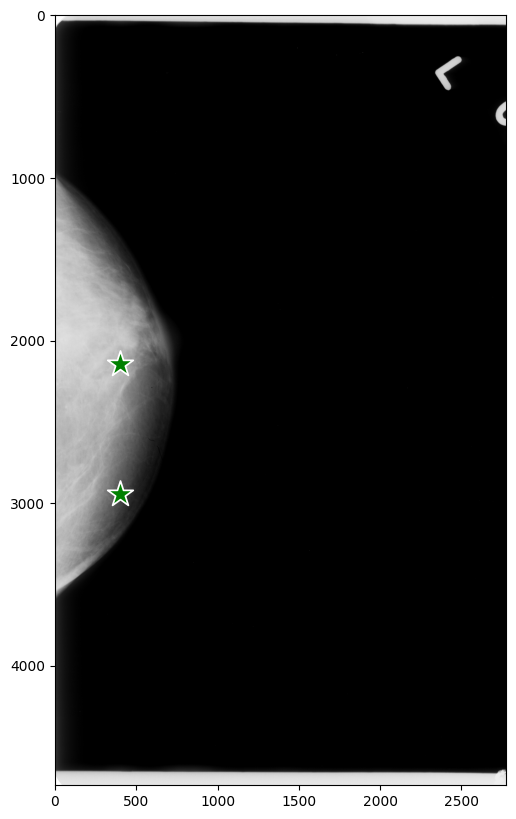

In [ ]:
(x1, y1, x2, y2) = (400, 2946, 400, 2146)
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([1, 1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [299]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [302]:
# two points
#mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    #mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [303]:
masks.shape  # (number_of_masks) x H x W

(1, 4736, 2776)

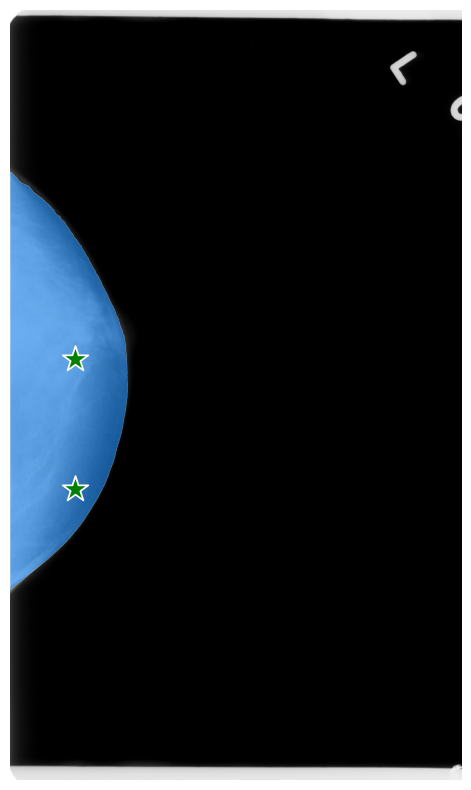

In [304]:
#show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

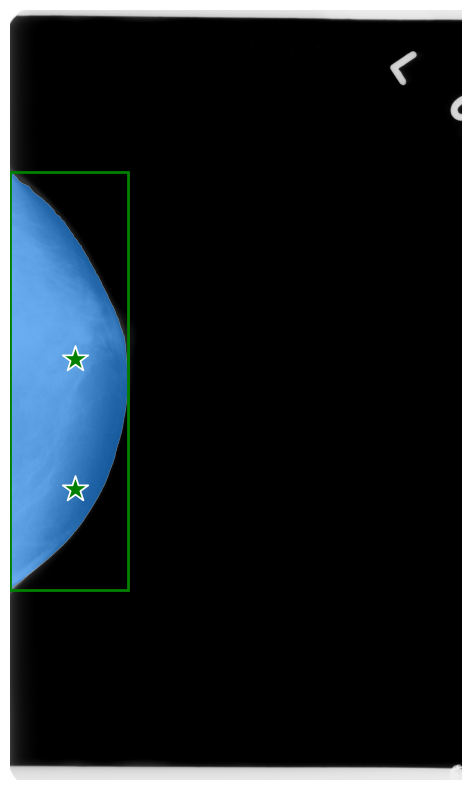

In [305]:
# Get the bounding box from the mask
bbox = get_bounding_box(masks[0])  # Use the first mask

# Display the image with the mask and bounding box
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, box_coords=bbox, borders=True)


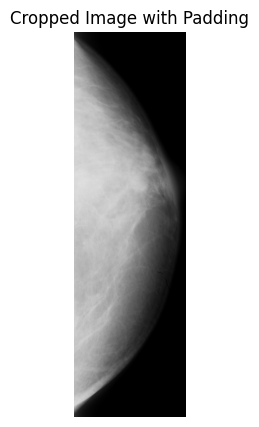

In [306]:
bbox = get_bounding_box(masks[0])  # Get bounding box from the mask

if bbox:
    expanded_bbox = expand_bounding_box(bbox, image.shape, padding=50)  # Add 50px padding
    cropped_image = crop_image(image, expanded_bbox)  # Crop using the expanded box

    # Display cropped image
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image)
    plt.axis("off")
    plt.title("Cropped Image with Padding")
    plt.show()


In [ ]:
from tqdm import tqdm

# Crop all images in the dataset
def crop_all(topDirectory):
    """
    Applies breast tissue segmentation and cropping to all mammogram images in a given dataset directory
    using the Segment Anything Model (SAM). The function processes each image by detecting foreground points,
    generating segmentation masks, computing bounding boxes, and saving the cropped result.

    Parameters:
        topDirectory (str): The top-level path of the dataset folder containing 'images' and 'labels' subfolders.

    Output:
        A new folder is created in /kaggle/working/ named "<original-folder>-cropped" which contains:
            - Cropped images in 'images/' subfolder
            - Copied label files in 'labels/' subfolder
    """
    images_path = topDirectory + "/images"
    labels_path = topDirectory + "/labels"

    new_path = "/kaggle/working/" + os.path.basename(topDirectory) + "-cropped"

    # Create new folder
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    # Create new directories for images and labels if they don't exist yet
    if not os.path.exists(new_path + "/images"):
        os.makedirs(new_path + "/images")
        print("SUCCESS> ", new_path + "/images", " was created")
    if not os.path.exists(new_path + "/labels"):
        os.makedirs(new_path + "/labels")
        print("SUCCESS> ", new_path + "/labels", " was created")

    # Copy labels file into the new folder
    for _, _, files in os.walk(labels_path):
        if not os.path.exists(new_path + "/labels/" + files[0]):
            shutil.copy(labels_path + "/" + files[0], new_path + "/labels")
            print("SUCCESS> ", files[0], " was copied into ", new_path + "/labels")
    
    # Find mask and bounding box, crop and save image
    for _, _, files in os.walk(images_path):
        for img_file in tqdm(files, desc="Processing Images", unit="image"):
            # construct full image path (original and new)
            img_path = images_path + "/" + img_file
            new_img_path = new_path + "/images/" + img_file
            
            # open image
            image = Image.open(img_path)
            image = np.array(image.convert("RGB"))
            
            # get coords of point on breast
            (x1, y1, x2, y2) = get_coords(img_path, image)
            if (x1, y1, x2, y2) == (-1, -1, -1, -1):
                continue
            
            # process the image to produce an image embedding
            predictor.set_image(image)
            
            # declare input point and label using coords
            input_point = np.array([[x1, y1], [x2, y2]])
            input_label = np.array([1, 1])
            
            # make predictions on two points
            masks, scores, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False,
            )
            
            # get bounding box, given the mask
            bbox = get_bounding_box(masks[0])  # Get bounding box from the mask
            
            # expand the bounding box before cropping the image
            if bbox:
                expanded_bbox = expand_bounding_box(bbox, image.shape, padding=50)  # Add 50px padding
                cropped_image = crop_image(image, expanded_bbox)  # Crop using the expanded box
                    
            # convert NumPy array to PIL image
            cropped_pil = Image.fromarray(cropped_image)
            
            # save the image as PNG
            if not os.path.exists(new_img_path):
                cropped_pil.save(new_img_path, format="PNG")
            else:
                print(new_img_path, " already exists!")

In [ ]:
from tqdm import tqdm

# Crop one image in the dataset, given specific coordinates
def crop_one_image(topDirectory, img_path, coords):
    """
    Crops a single mammogram image using the Segment Anything Model (SAM), 
    given a pair of coordinates indicating points on the breast tissue.

    This function is useful for testing or manually processing specific images.
    
    Parameters:
        topDirectory (str): Path to the dataset folder containing 'images' and 'labels' subfolders.
        img_path (str): Full path to the specific image to crop.
        coords (tuple): A tuple of 4 integers representing two (x, y) coordinates (x1, y1, x2, y2)
                        used as input prompts for SAM.

    Output:
        - The cropped image is saved in a new path under "/kaggle/working/<dataset>-cropped/images/".
        - The cropped image is also displayed for visual confirmation.
    """
    
    images_path = topDirectory + "/images"
    labels_path = topDirectory + "/labels"

    new_path = "/kaggle/working/" + os.path.basename(topDirectory) + "-cropped"

    new_img_path = new_path + "/images/" + os.path.basename(img_path)

    # Find mask and bounding box, crop and save image
    if os.path.exists(new_path + "/images") and not os.path.exists(new_img_path):
        # open image
        image = Image.open(img_path)
        image = np.array(image.convert("RGB"))
            
        # get coords of point on breast
        (x1, y1, x2, y2) = coords
            
        # process the image to produce an image embedding
        predictor.set_image(image)
            
        # declare input point and label using coords
        input_point = np.array([[x1, y1], [x2, y2]])
        input_label = np.array([1, 1])
            
        # make predictions on two points
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
        )

            
        # get bounding box, given the mask
        bbox = get_bounding_box(masks[0])  # Get bounding box from the mask
        
        # expand the bounding box before cropping the image
        if bbox:
            expanded_bbox = expand_bounding_box(bbox, image.shape, padding=50)  # Add 50px padding
            cropped_image = crop_image(image, expanded_bbox)  # Crop using the expanded box
        
        # Display cropped image
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_image)
        plt.axis("off")
        plt.title("Cropped Image with Padding")
        plt.show()
        
        # convert NumPy array to PIL image
        cropped_pil = Image.fromarray(cropped_image)
        
        # save the image as PNG
        cropped_pil.save(new_img_path, format="PNG")     
        print(os.path.basename(img_path), " cropped and saved under ", new_img_path)
    else:
        print(new_img_path, " already exists!")

In [ ]:
# crop all calcification test images
root = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png"
crop_all(root)

In [256]:
#shutil.rmtree("/kaggle/working/Calc-Test-png-cropped", ignore_errors = True)

In [ ]:
# manually crop these two images
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png/images/Calc-Test_P_01460_RIGHT_CC_FULL.png"
image_path1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png/images/Calc-Test_P_01030_RIGHT_CC_FULL.png"

x, y = 2500, 2000
#crop_one_image(root, image_path, (x,y))

In [251]:
#!zip -r Calc-Test-png-cropped.zip /kaggle/working/Calc-Test-png-cropped

In [255]:
#os.remove("Calc-Test-png-cropped.zip")

In [ ]:
# crop all calcification training images
root1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png"
crop_all(root1)

In [200]:
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00734_RIGHT_CC_FULL.png"
image_path1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_01846_RIGHT_MLO_FULL.png"

x, y = 2600, 2000
#crop_one_image(root1, image_path, (x,y))

In [293]:
#!zip -r Calc-Training-png-cropped.zip /kaggle/working/Calc-Training-png-cropped

In [ ]:
# Create new folder
new_path = "/kaggle/working/Calc-Training-png-cropped"
if not os.path.exists(new_path):
    os.makedirs(new_path)
if not os.path.exists(new_path + "/images"):
    os.makedirs(new_path + "/images")
    print("SUCCESS> ", new_path + "/images", " was created")


In [202]:
# images that need adjusted points 
root1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png"
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00573_RIGHT_MLO_FULL.png"
image_path1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00635_LEFT_MLO_FULL.png"
image_path2 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00784_RIGHT_MLO_FULL.png"
image_path3 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00967_RIGHT_CC_FULL.png"
image_path4 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_00991_LEFT_CC_FULL.png"
image_path5 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_01010_RIGHT_MLO_FULL.png"
image_path6 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_01234_RIGHT_CC_FULL.png"
image_path7 = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png/images/Calc-Training_P_01736_LEFT_CC_FULL.png"

x, y = 2026, 3641
#crop_one_image(root1, image_path7, (x,y))

In [204]:
#shutil.rmtree("/kaggle/working/Calc-Training-png-cropped", ignore_errors = True)

In [ ]:
# crop all mass test images
root2 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Test-png"
crop_all(root2)

In [64]:
# images that need adjusted points 
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Test-png/images/Mass-Test_P_00037_RIGHT_CC_FULL.png"
image_path1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Test-png/images/Mass-Test_P_01815_RIGHT_CC_FULL.png"

(x1, y1, x2, y2) = (2240, 2664, 2240, 2064)
#crop_one_image(root2, image_path1, (x1, y1, x2, y2))

In [62]:
#!zip -r Mass-Test-png-cropped.zip /kaggle/working/Mass-Test-png-cropped

In [66]:
#os.remove("Mass-Test-png-cropped.zip")

In [67]:
#shutil.rmtree("/kaggle/working/Mass-Test-png-cropped", ignore_errors = True)

In [ ]:
# crop all mass training images
root3 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png"
crop_all(root3)

In [70]:
#!zip -r Mass-Training-png-cropped.zip /kaggle/working/Mass-Training-png-cropped

In [71]:
#os.remove("Mass-Training-png-cropped.zip")
#shutil.rmtree("/kaggle/working/Mass-Training-png-cropped", ignore_errors = True)

In [ ]:
# Create new folder
new_path = "/kaggle/working/Mass-Training-png-cropped"
if not os.path.exists(new_path):
    os.makedirs(new_path)
if not os.path.exists(new_path + "/images"):
    os.makedirs(new_path + "/images")
    print("SUCCESS> ", new_path + "/images", " was created")


In [289]:
# images that need adjusted points 
root3 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png"
image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01474_RIGHT_MLO_FULL.png"
image_path1 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00997_LEFT_MLO_FULL.png"
image_path2 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01406_LEFT_MLO_FULL.png"
image_path3 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00753_RIGHT_MLO_FULL.png"
image_path4 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00903_LEFT_MLO_FULL.png"
image_path5 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01606_RIGHT_MLO_FULL.png"
image_path6 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00829_LEFT_CC_FULL.png"
image_path7 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01305_LEFT_CC_FULL.png"
image_path8 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00997_LEFT_CC_FULL.png"
image_path9 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01305_LEFT_MLO_FULL.png"
image_path10 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01000_RIGHT_MLO_FULL.png"
image_path11 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00841_RIGHT_MLO_FULL.png"
image_path12 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_00568_LEFT_CC_FULL.png"
image_path13 = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png/images/Mass-Training_P_01829_LEFT_MLO_FULL.png"

(x1, y1, x2, y2) = (2176, 4046, 2176, 2446)
#crop_one_image(root3, image_path13, (x1, y1, x2, y2))

# Flip Left-View Images

In [81]:
import matplotlib.pyplot as plt
from PIL import Image

from math import ceil

import cv2
import numpy as np

def black_pixel(pixel, threshold=20):
    """Checks if the given RGB pixel is black or nearly black.
    Return True if the pixel is black or near-black, False otherwise"""
    return np.all(pixel <= threshold)  # Check if all RGB values are below the threshold

def get_orientation(img_path, img, threshold=30):
    # initially assume the image name correctly gives the position of the breast in the image
    y1 = ceil(img.shape[0]/2) 
    
    if "LEFT" in img_path:
        x1 = ceil(img.shape[1]/10)
        if not black_pixel(img[y1, x1], threshold):
            return "LEFT"
    else:
        x1 = ceil(9 * img.shape[1]/10)
        if not black_pixel(img[y1, x1], threshold):
            return "RIGHT"

    if black_pixel(img[y1, x1], threshold):
        if "LEFT" in img_path:
            x1 = ceil(9 * img.shape[1]/10)
            if not black_pixel(img[y1, x1], threshold):
                return "RIGHT"
        else:
            x1 = ceil(img.shape[1]/10)
            if not black_pixel(img[y1, x1], threshold):
                return "LEFT"

        if black_pixel(img[y1, x1], threshold):
            # try again with lower threshold
            print("trying lower threshold")
            if threshold >= 10 :
                orient = get_orientation(img_path, img, threshold=threshold - 5)
                if orient == -1:
                    return -1
                else:
                    return orient
            else:
                print("No point found: ", img_path)
                return -1


In [7]:
from tqdm import tqdm

# Flip left view images in the dataset
# Loop through images in the original dataset, since it will be easier to detect 
# if the image needs to be flipped. Then take the cropped image and either flip it, or 
# save it as it is in the new directory
def flip_all(originalTopDirectory, croppedTopDirectory):
    images_path = originalTopDirectory + "/images"
    labels_path = originalTopDirectory + "/labels"

    new_path = "/kaggle/working/" + os.path.basename(originalTopDirectory) + "-flipped"

    # Create new folder
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    # Create new directories for images and labels if they don't exist yet
    if not os.path.exists(new_path + "/images"):
        os.makedirs(new_path + "/images")
        print("SUCCESS> ", new_path + "/images", " was created")
    if not os.path.exists(new_path + "/labels"):
        os.makedirs(new_path + "/labels")
        print("SUCCESS> ", new_path + "/labels", " was created")

    # Copy labels file into the new folder
    for _, _, files in os.walk(labels_path):
        if not os.path.exists(new_path + "/labels/" + files[0]):
            shutil.copy(labels_path + "/" + files[0], new_path + "/labels")
            print("SUCCESS> ", files[0], " was copied into ", new_path + "/labels")
        

    # Get original image orientation, flip if orientation is left, save
    for _, _, files in os.walk(images_path):
        for img_file in tqdm(files, desc="Processing Images", unit="image"):
            # construct full image path (original, cropped, and new)
            original_img_path = images_path + "/" + img_file
            cropped_img_path = croppedTopDirectory + "/images/" + img_file
            new_img_path = new_path + "/images/" + img_file
            
            # open original image
            original_image = Image.open(original_img_path)
            original_image = np.array(original_image.convert("RGB"))
            
            # get orientation
            orientation = get_orientation(original_img_path, original_image)
            if orientation == -1:
                continue
            elif orientation == "LEFT":
                # open cropped image
                cropped_image = Image.open(cropped_img_path)
                cropped_image = np.array(cropped_image.convert("RGB"))
                # Flip the cropped image horizontally
                cropped_image = Image.fromarray(cropped_image)  # Convert NumPy array back to PIL
                flipped_image = cropped_image.transpose(Image.FLIP_LEFT_RIGHT)  # Flip horizontally
                # save the image as PNG
                if not os.path.exists(new_img_path):
                    flipped_image.save(new_img_path, format="PNG")
                else:
                    print(new_img_path, " already exists!")
            else:
                # save image in new path without modifying it
                if not os.path.exists(new_img_path):
                    shutil.copy(cropped_img_path, new_img_path)
                else:
                    print(new_img_path, " already exists!")

In [ ]:
# test one image 
original_image_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png/images/Calc-Test_P_01303_LEFT_CC_FULL.png"
cropped_image_path = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Test-png-cropped/images/Calc-Test_P_01303_LEFT_CC_FULL.png"

# open image
original_image = Image.open(original_image_path)
original_image = np.array(original_image.convert("RGB"))

# get orientation
orientation = get_orientation(original_image_path, original_image)
if orientation == "LEFT":
    # open cropped image
    cropped_image = Image.open(cropped_image_path)
    cropped_image = np.array(cropped_image.convert("RGB"))
    # Flip the cropped image horizontally
    cropped_image = Image.fromarray(cropped_image)  # Convert NumPy array back to PIL
    flipped_image = cropped_image.transpose(Image.FLIP_LEFT_RIGHT)  # Flip horizontally
    print("flipped image")
    # Display flipped image
    plt.figure(figsize=(5, 5))
    plt.imshow(flipped_image)
    plt.axis("off")
    plt.show()
else:
    print("no need to flip")
    # Display image
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()



In [ ]:
# flip all calc test images
original_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Test-png"
cropped_path = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Test-png-cropped"

flip_all(original_path, cropped_path)

In [34]:
#!zip -r Calc-Test-png-flipped.zip /kaggle/working/Calc-Test-png-flipped

In [78]:
#os.remove("Calc-Test-png-flipped.zip")
#shutil.rmtree("/kaggle/working/Calc-Training-png-flipped", ignore_errors = True)

In [ ]:
# flip all calc training images
original_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Calc-Training-png"
cropped_path = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Training-png-cropped"

flip_all(original_path, cropped_path)

In [89]:
#!zip -r Calc-Training-png-flipped.zip /kaggle/working/Calc-Training-png-flipped

In [91]:
#os.remove("Calc-Training-png-flipped.zip")
#shutil.rmtree("/kaggle/working/Calc-Training-png-flipped", ignore_errors = True)

In [ ]:
# flip all mass training images
original_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Training-png"
cropped_path = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Training-png-cropped"

flip_all(original_path, cropped_path)

In [94]:
#!zip -r Mass-Training-png-flipped.zip /kaggle/working/Mass-Training-png-flipped

In [97]:
#os.remove("Mass-Training-png-flipped.zip")
#shutil.rmtree("/kaggle/working/Mass-Training-png-flipped", ignore_errors = True)

In [ ]:
# flip all mass training images
original_path = "/kaggle/input/cbis-ddsm-dataset/Data png/Mass-Test-png"
cropped_path = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Test-png-cropped"

flip_all(original_path, cropped_path)

In [100]:
#!zip -r Mass-Test-png-flipped.zip /kaggle/working/Mass-Test-png-flipped

In [102]:
#os.remove("Mass-Test-png-flipped.zip")
#shutil.rmtree("/kaggle/working/Mass-Test-png-flipped", ignore_errors = True)